In [47]:
! pip install pandarallel
! pip install textblob
! pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize, sent_tokenize
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from pandarallel import pandarallel
import warnings
from os.path import exists

warnings.filterwarnings('ignore')

pandarallel.initialize(progress_bar=True)

  # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Load data
trainingSet = pd.read_csv("/content/drive/MyDrive/train_sample.csv")
testSet = pd.read_csv("/content/drive/MyDrive/data/test.csv")

In [29]:
train_sample = trainingSet.copy()

# Handle NaN in 'Text' and 'Summary'
train_sample['Text'] = train_sample['Text'].fillna('')
train_sample['Summary'] = train_sample['Summary'].fillna('')

# Data Preprocessing
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}

def preprocess_text(text):
    if not text:
        return ''
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters except ! and ?
    text = re.sub(r'[^a-z!\?\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# print some stats
train_sample['Score'].value_counts()

,count
Score,
5.0,793163
4.0,335228
3.0,176082
1.0,91190
2.0,89678


In [31]:
train_sample['CleanedText'] = train_sample['Text'].parallel_apply(preprocess_text)
train_sample['CleanedSummary'] = train_sample['Summary'].parallel_apply(preprocess_text)
train_sample['CombinedText'] = train_sample['CleanedSummary'] + " " + train_sample['CleanedText']

In [32]:
print(train_sample.shape)

(1697533, 25)


In [33]:
NEGATIVE_WORDS = [
    'not', 'no', "n't", 'never', 'neither', 'nor', 'without', 'barely', 'worst', 'hardly', 'none', 'bad',
    'worse', 'worst', 'less', 'least', 'no', 'nobody', 'nothing'
]

In [34]:
def add_features_to(df):
    # Helpfulness Ratio
    df['Helpfulness'] = np.where(
        df['HelpfulnessDenominator'] > 0,
        df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
        0
    )

    df['Helpfulness'] = df['Helpfulness'].replace([np.inf, -np.inf], 0)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    # Review Length
    df['ReviewLength'] = df['Text'].parallel_apply(lambda x: len(x.split()))
    # Sentiment Polarity using TextBlob
    df['Polarity'] = df['Text'].parallel_apply(lambda x: TextBlob(x).sentiment.polarity if x else 0)
    # Sentiment Shift
    def sentiment_shift(text):
        sentences = nltk.sent_tokenize(text)
        polarities = [TextBlob(sentence).sentiment.polarity for sentence in sentences if sentence]
        if polarities:
            return max(polarities) - min(polarities)
        else:
            return 0
    df['NegationCount'] = df['Text'].parallel_apply(lambda x: sum( 1 for word in x.split() if word.lower() in NEGATIVE_WORDS))
    # POS Tagging Counts
    def pos_counts(text):
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = nltk.FreqDist(tag for (word, tag) in tags)
        return counts
    df['ExclamationCount'] = df['Text'].parallel_apply(lambda x: x.count('!'))

    df['Number_of_Reviews_by_User'] = df.groupby('UserId')['UserId'].transform('count')
    df['Number_of_Reviews_for_Product'] = df.groupby('ProductId')['ProductId'].transform('count')

    df['Helpfulness_Deviation'] = df['Helpfulness'] - df.groupby('UserId')['Helpfulness'].transform('mean')
    df['Sentiment_Deviation'] = df['Polarity'] - df.groupby('ProductId')['Polarity'].transform('mean')

    user_avg_deviation = df.groupby('UserId')['Helpfulness_Deviation'].mean()
    df['User_Avg_Deviation'] = df['UserId'].map(user_avg_deviation)

    product_avg_sentiment = df.groupby('ProductId')['Polarity'].mean()
    df['Product_Avg_Sentiment'] = df['ProductId'].map(product_avg_sentiment)

    return df

# parallel_apply feature engineering
train_sample = add_features_to(train_sample)

In [35]:
train_sample.shape

(1697533, 26)

In [36]:
train_sample = trainingSet.copy()

In [37]:
# add TFIDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2),
    analyzer='word',
    stop_words='english'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(train_sample['CombinedText'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
train_sample = pd.concat([train_sample, tfidf_df], axis=1)

In [38]:
X_train =  train_sample[train_sample['Score'].notnull()]
y_train = X_train['Score']

In [39]:
train_sample.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,CleanedText,...,years,years ago,yes,york,youll,young,younger,youre,youve,zombie
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0,straight dvd films not worth watching one exce...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0,wanted one sometime also enjoy william powell ...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0,actually pretty darn good indie film appears w...,...,0.0,0.0,0.0,0.0,0.0,0.187892,0.0,0.0,0.0,0.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0,episodes series press refined approach fist no...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0,really impressed movie wasnt big fan artificia...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [40]:
print(list(train_sample.columns))

['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score', 'CleanedText', 'CleanedSummary', 'CombinedText', 'Helpfulness', 'ReviewLength', 'Polarity', 'Subjectivity', 'SentimentShift', 'NegationCount', 'ExclamationCount', 'Number_of_Reviews_by_User', 'Number_of_Reviews_for_Product', 'Helpfulness_Deviation', 'Sentiment_Deviation', 'User_Avg_Deviation', 'Product_Avg_Sentiment', 'able', 'absolutely', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'actually', 'adaptation', 'add', 'added', 'addition', 'admit', 'adult', 'adults', 'adventure', 'age', 'ago', 'agree', 'air', 'alien', 'alive', 'amazing', 'amazon', 'america', 'american', 'animated', 'animation', 'anime', 'annoying', 'apparently', 'appear', 'appears', 'appreciate', 'arent', 'art', 'ask', 'aspect', 'attempt', 'attention', 'audience', 'audio', 'available', 'average', 'away', 'awesome', 'awful', 'baby', 'background', 'bad', 'band', 'based', 'basic',

In [42]:
# Fill NaN in numerical features
numerical_features = [
    'ReviewLength', 'Polarity', 'Subjectivity',
    'SentimentShift',
    'ExclamationCount', 'NegationCount', 'Number_of_Reviews_by_User',
    'Number_of_Reviews_for_Product', 'Helpfulness_Deviation',
    'Sentiment_Deviation', 'User_Avg_Deviation', 'Product_Avg_Sentiment'
]

# Fill NaN in train_sample
for feature in numerical_features:
    train_sample[feature] = train_sample[feature].fillna(train_sample[feature].median())

In [51]:
features = [
    'Id',
    'ProductId',
    'UserId',
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Summary',
    'Text',
    'CleanedText',
    'CleanedSummary',
    'CombinedText',
    'Helpfulness',
    'ReviewLength',
    'Polarity',
    'Subjectivity',
    'SentimentShift',
    'NegationCount',
    'ExclamationCount',
    'Number_of_Reviews_by_User',
    'Number_of_Reviews_for_Product',
    'Helpfulness_Deviation',
    'Sentiment_Deviation',
    'User_Avg_Deviation',
    'Product_Avg_Sentiment',
    'Product_Avg_Rating'
]

tfidf_features = [col for col in train_sample.columns if col not in features]

to_leave = tfidf_features + numerical_features
to_leave = to_leave

print(to_leave)

['Score', 'able', 'absolutely', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'actually', 'adaptation', 'add', 'added', 'addition', 'admit', 'adult', 'adults', 'adventure', 'age', 'ago', 'agree', 'air', 'alien', 'alive', 'amazing', 'amazon', 'america', 'american', 'animated', 'animation', 'anime', 'annoying', 'apparently', 'appear', 'appears', 'appreciate', 'arent', 'art', 'ask', 'aspect', 'attempt', 'attention', 'audience', 'audio', 'available', 'average', 'away', 'awesome', 'awful', 'baby', 'background', 'bad', 'band', 'based', 'basic', 'basically', 'batman', 'battle', 'beautiful', 'beautifully', 'beauty', 'begin', 'beginning', 'begins', 'believable', 'believe', 'ben', 'best', 'better', 'big', 'bit', 'black', 'blood', 'blu', 'blu ray', 'blue', 'bluray', 'body', 'bond', 'bonus', 'book', 'books', 'boring', 'bought', 'box', 'boy', 'boys', 'break', 'brief', 'brilliant', 'bring', 'brings', 'british', 'brother', 'brothers', 'brought', 'bruce', 'budget', 'bunch

In [43]:
X_train = X_train[to_leave]

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    y_train,
    test_size=0.25,
    random_state=0
)

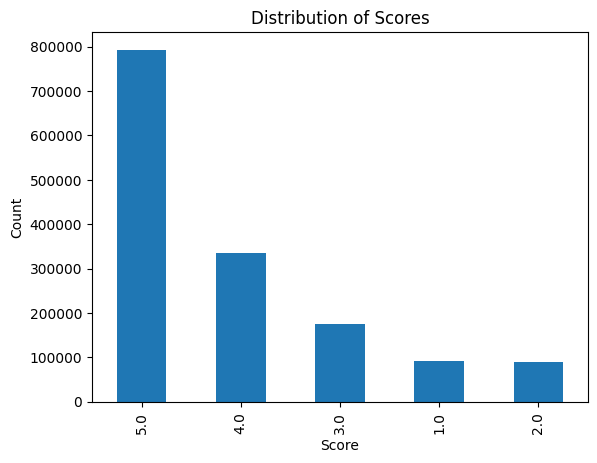

In [49]:
# show some cool data

# show distribbution of scores using a histogram

train_sample['Score'].value_counts().plot(kind='bar')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# show most frequent words as a word map

from wordcloud import WordCloud
train_sample['Text'] = train_sample['Text'].fillna('')
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(train_sample['Text']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

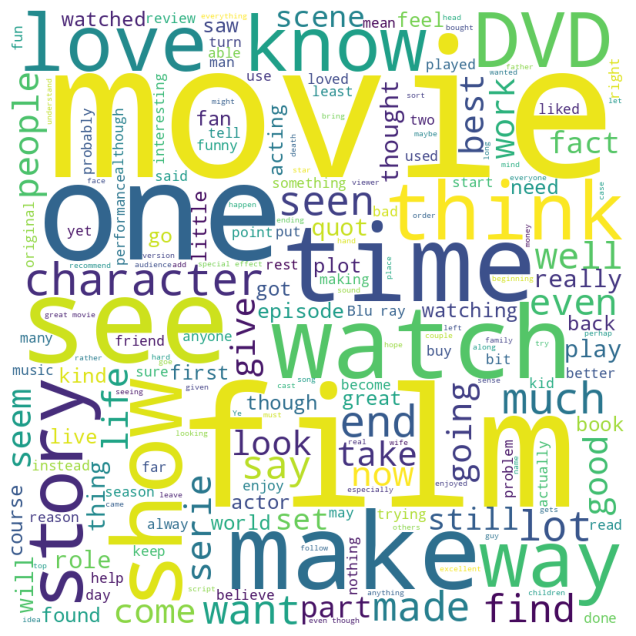

In [50]:
# show some more data



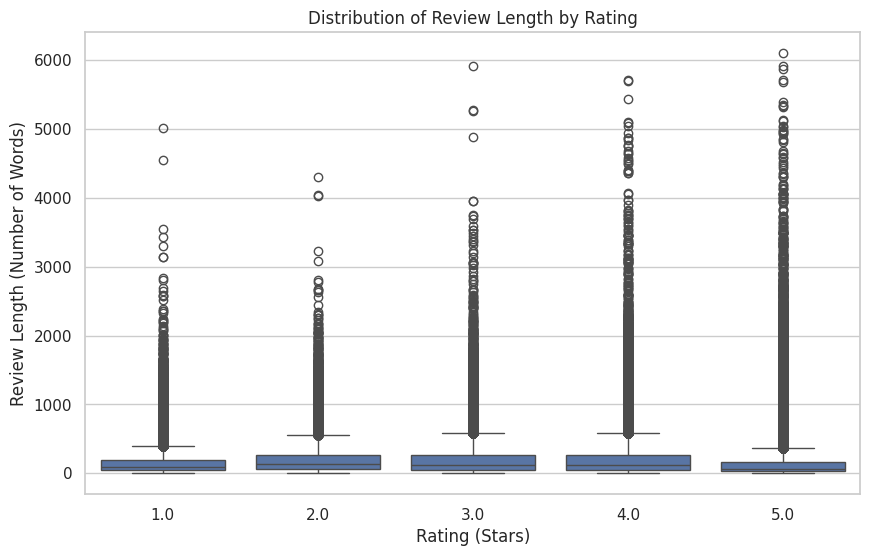

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a box plot for Review Length by Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='ReviewLength', data=train_sample)
plt.title('Distribution of Review Length by Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Review Length (Number of Words)')
plt.show()


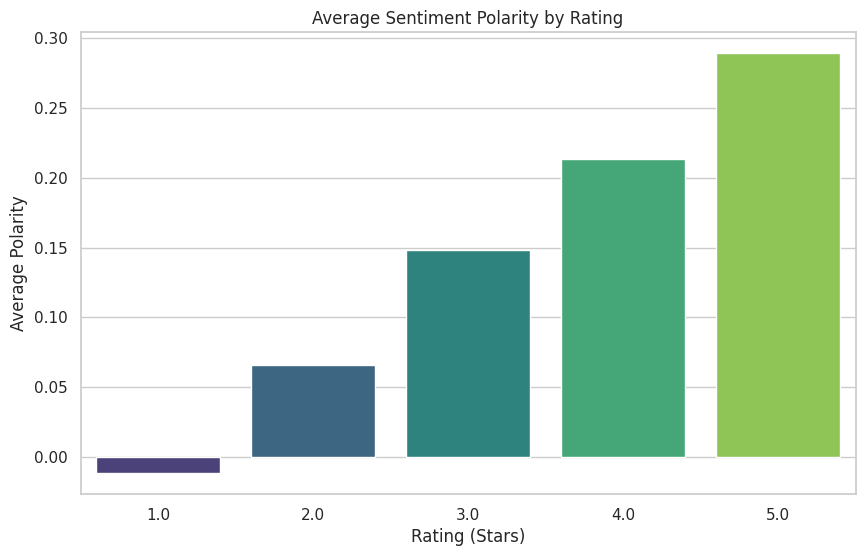

In [54]:
# Calculate average polarity for each rating
avg_polarity = train_sample.groupby('Score')['Polarity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Polarity', data=avg_polarity, palette='viridis')
plt.title('Average Sentiment Polarity by Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Average Polarity')
plt.show()

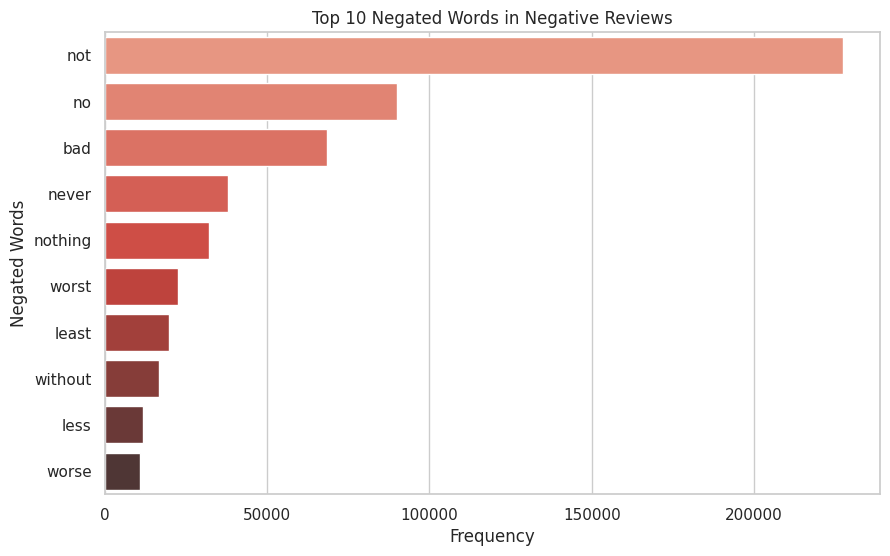

In [61]:
from collections import Counter

# Filter negative reviews (e.g., 1 and 2 stars)
negative_reviews = train_sample[train_sample['Score'] <= 2]

# Extract negated words
negated_words = []
for text in negative_reviews['CombinedText']:
    words = text.split()
    negations = [word for word in words if word.lower() in NEGATIVE_WORDS]
    negated_words.extend(negations)

# Count the most common negated words
neg_word_counts = Counter(negated_words).most_common(10)
words, counts = zip(*neg_word_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='Reds_d')
plt.title('Top 10 Negated Words in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Negated Words')
plt.show()


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_leaf_nodes=80,
    min_samples_leaf=40,
    random_state=42
)

model.fit(X_train, Y_train)

Evaluating HistGradientBoostingClassifier:
Accuracy: 0.6403
Weighted F1 Score: 0.6135
Classification Report:
              precision    recall  f1-score   support

         1.0       0.58      0.56      0.57     22906
         2.0       0.39      0.21      0.27     22406
         3.0       0.45      0.31      0.37     44171
         4.0       0.47      0.35      0.40     83810
         5.0       0.73      0.89      0.80    198043

    accuracy                           0.64    371336
   macro avg       0.52      0.47      0.48    371336
weighted avg       0.61      0.64      0.61    371336



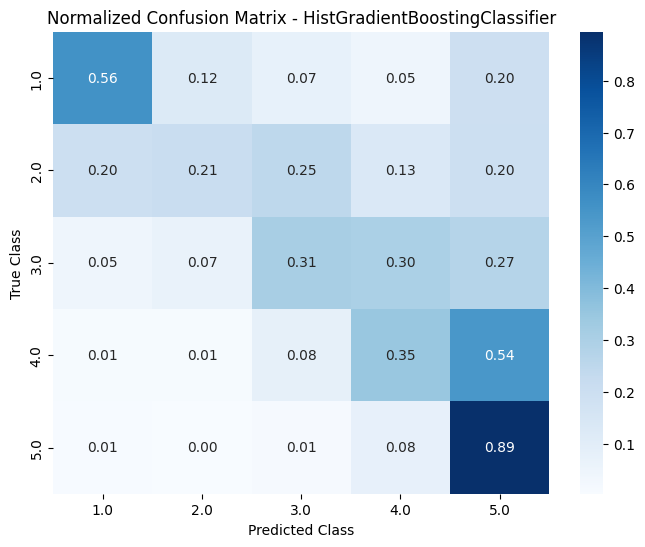

In [24]:
def evaluate_model(model, X_val, Y_val, model_name):
    Y_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_pred)
    f1 = f1_score(Y_val, Y_pred, average='weighted')
    print(f"Evaluating {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(Y_val, Y_pred))
    # Confusion Matrix
    cm = confusion_matrix(Y_val, Y_pred, labels=sorted(Y_val.unique()))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=sorted(Y_val.unique()), yticklabels=sorted(Y_val.unique()))
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

evaluate_model(model, X_test, Y_test, "HistGradientBoostingClassifier")

In [25]:
X_submission = pd.merge(train_sample, testSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

for feature in numerical_features:
    X_submission[feature] = X_submission[feature].fillna(train_sample[feature].median())

X_submission.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,CleanedSummary,...,years ago,yes,york,youll,young,younger,youre,youve,zombie,Score
0,1323432,B0034G4P30,A120UTHQDQIJGH,0,0,1391040000,Okay for a rental,This movie was just alright for me. I think pe...,movie alright think people saying ensemble cas...,okay rental,...,0.000000,0.142873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1137299,B0012IWO0I,A3SJBFCTJWBFT2,1,1,1388188800,Great for kids,My kids love this movie. Exciting and fun to ...,kids love movie exciting fun watch well writte...,great kids,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1459366,B005FUTBSC,A1V6FRU7EXP6N9,0,0,1356739200,good movie,"The effects were good, not the best but far fr...",effects good not best far worst liked story re...,good movie,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,931601,B000AREXBU,ARXDDR76Z5Q2I,5,5,1169510400,Excellent quality dvd. Don't pay big bucks fo...,"I just got a copy of this S. Korean dvd of ""He...",got copy korean dvd help great print quality e...,excellent quality dvd dont pay big bucks mpi v...,...,0.168017,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1311995,B002ZG99B8,A2XAS9GVZL3B1,2,2,1392595200,A mixed review,"OK, to put this clearly and bluntly... if you ...",ok put clearly bluntly real fan tv show van wi...,mixed review,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
